In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

# Funs

In [2]:
from tensorflow.keras import backend as K
def prep_data(sim):
    X = np.stack([eeg.average().data for eeg in sim.eeg_data])
    y = np.stack([src.data for src in sim.source_data])
    for i, (x_sample, y_sample) in enumerate(zip(X, y)):
        # X[i] = np.stack([(x - np.mean(x)) / np.std(x) for x in x_sample.T], axis=0).T
        # y[i] = np.stack([ y / np.max(abs(y)) for y in y_sample.T], axis=0).T

        X[i] = np.stack([x - np.mean(x) for x in x_sample.T], axis=0).T
        X[i] = np.stack([x / np.std(x) for x in x_sample.T], axis=0).T
        
        # X[i] /= np.linalg.norm(X[i])
        y[i] /= np.max(abs(y[i]))

    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    
    return X, y
    
def make_mask(y, thresh=0.01):
    return np.stack([abs(yy)>abs(yy).max()*thresh for yy in y[:, 0]], axis=0).astype(float)

def get_components(X, leadfield_norm):
    X_norm = (X[:, 0].T / np.linalg.norm(X[:, 0], axis=1)).T
    X_norm = X_norm[:, np.newaxis]
    X_components = (leadfield_norm.T @ X_norm[:, 0, :].T).T
    return X_components

def clipped_linear(x, a_min=-1, a_max=1):
    return K.clip(x, a_min, a_max)

def generator(batch_size, leadfield, n_sources=(1, 15)):
    leadfield -= leadfield.mean(axis=0)
    leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)
    n_chans, n_dipoles = leadfield.shape

    dipoles = np.arange(n_dipoles)
    while True:
        numbers = np.random.randint(*n_sources, batch_size)
        y = np.zeros((batch_size, n_dipoles))
        x = np.zeros((batch_size, n_chans))
        
        for sample in range(batch_size):
            current_indices = np.random.choice(dipoles, numbers[sample])
            y[sample, current_indices] = np.random.rand(numbers[sample])*2-1
            x[sample, :] = leadfield @ y[sample]
        x_norm = (x.T / np.linalg.norm(x, axis=1)).T
        x_comp = (leadfield_norm.T @ x_norm.T).T
        # x_comp = (x_comp.T / x_comp.std(axis=1)).T
        y = (y.T / abs(y).max(axis=1)).T
        yield (x_comp[:, np.newaxis], y[:, np.newaxis])

def generator_x(batch_size, leadfield, n_sources=(1, 15)):
    leadfield -= leadfield.mean(axis=0)
    leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)
    n_chans, n_dipoles = leadfield.shape

    dipoles = np.arange(n_dipoles)
    while True:
        # print("next")
        numbers = np.random.randint(*n_sources, batch_size)
        y = np.zeros((batch_size, n_dipoles))
        x = np.zeros((batch_size, n_chans))
        
        for sample in range(batch_size):
            current_indices = np.random.choice(dipoles, numbers[sample])
            y[sample, current_indices] = np.random.rand(numbers[sample])*2-1
            x[sample, :] = leadfield @ y[sample]
        x = (x.T - np.mean(x, axis=1)).T
        x_norm = (x.T / np.std(x, axis=1)).T
        y = (y.T / abs(y).max(axis=1)).T
        yield (x_norm[:, np.newaxis], y[:, np.newaxis])

# x_comp, y = generator(32, leadfield).__next__()
# x, y = generator_x(32, leadfield, n_sources=(1,8)).__next__()
# print(y.min())

# Forward

In [3]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)

n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


# Simulation

In [4]:
settings = dict(
    number_of_sources=(1, 5), 
    extents=1, 
    duration_of_trial=0.001, 
    target_snr=1e99, 
    source_number_weighting=False
    )


sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()


X, y = prep_data(sim)
X_components = get_components(X, leadfield_norm)

y_mask = make_mask(y)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
 50%|█████     | 1/2 [00:00<00:00,  2.33it/s]c:\Users\Lukas\Envs\invertenv\lib\site-packages\esinet\simulation.py:387: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.simulation_info = self.simulation_info.append(d, ignore_index=True)
100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 1) (1284, 1)


100%|██████████| 2/2 [00:00<00:00, 668.63it/s]


# Train

## FC Model

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout, add, multiply, BatchNormalization
from tensorflow.keras import backend as K
tf.keras.backend.set_image_data_format('channels_last')
loss = lambda y_true, y_pred: K.mean(K.abs( (y_true / tf.norm(y_true)) - (y_pred / tf.norm(y_pred))  ))
n_channels, n_dipoles = leadfield.shape
n_time = 1#X.shape[1]

n_dense_units = 300
n_lstm_units = 64
activation_function = "tanh"
batch_size = 1000
epochs = 500
dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')

fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function,
            name='FC1'))(inputs)

# fc1 = BatchNormalization()(fc1)

# fc2 = TimeDistributed(Dense(n_dense_units, 
#             activation=activation_function,
#             name='FC2'))(fc1)

# addition = add([fc1, fc2])


out = TimeDistributed(Dense(n_dipoles, 
            activation=clipped_linear, 
            # activity_regularizer=tf.keras.regularizers.L1(l1=0.001),
            name='Output'))(fc1)


model = tf.keras.Model(inputs=inputs, outputs=out, name='Prelocalizer')
model.compile(loss="cosine_similarity", optimizer="adam")
# model.compile(loss="mse", optimizer="adam")
# model.compile(loss="binary_crossentropy", optimizer="adam")

model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, min_delta=0.00, monitor="val_loss", restore_best_weights=True)]
# model.fit(X_components[:, np.newaxis], y_mask[:, np.newaxis], epochs=epochs, batch_size=batch_size, validation_split=0.15, callbacks=callbacks)
# model.fit(x=generator(batch_size, leadfield, n_sources=(1, 2)), epochs=epochs,  steps_per_epoch=100)
model.fit(x=generator_x(batch_size, leadfield, n_sources=(1, 8)), epochs=epochs,  steps_per_epoch=100)



Model: "Prelocalizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 1284)]      0         
                                                                 
 time_distributed_2 (TimeDis  (None, None, 300)        385500    
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1284)       386484    
 tributed)                                                       
                                                                 
Total params: 771,984
Trainable params: 771,984
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
100/100 [==============================] - 80s 803ms/step - loss: -0.0782
Epoch 2/500
100/100 [==============================] - 76s 764ms/step - loss: -0.1623
Epoch 3/

KeyboardInterrupt: 

# Test it

In [7]:
x_comp, y = generator(32, leadfield, n_sources=(2,3)).__next__()
# X, y = generator_x(32, leadfield, n_sources=(1,8)).__next__()
# x_comp = ((leadfield_norm.T @ X[:, 0].T).T)[:, np.newaxis]
# y_hat = model.predict(X)
y_hat = model.predict(x_comp)


plt.figure()
plt.subplot(411)
plt.plot(abs(y[0,0]))
plt.title("y")

plt.subplot(412)
plt.plot(X[0,0])
plt.title("components")

plt.subplot(413)
plt.plot(y_hat[0,0])
plt.title("output")

plt.subplot(414)
plt.plot(y_hat[0,0]*x_comp[0,0])
plt.title("multiplied")
plt.tight_layout()

stc_ = stc.copy()
stc_.data = y[:, 0].T
stc_.plot(**pp)

stc_.data = y_hat[:, 0].T
stc_.data /=stc_.data.max()
stc_.plot(**pp, clim=dict(kind="value", pos_lims=[0,0.5,1]))

stc_.data = x_comp[:, 0].T
stc_.plot(**pp)

stc_.data = (x_comp[:, 0] * y_hat[:, 0]).T
stc_.plot(**pp)

from scipy.stats import pearsonr
r = pearsonr(y[0,0], x_comp[0,0])[0]
print(f"components: r = {r:.2f}")
r = pearsonr(y[0,0], y_hat[0,0])[0]
print(f"model: r = {r:.2f}")

1/1 [==============================] - 0s 124ms/step
components: r = 0.05
model: r = 0.20


Using control points [0.        0.        0.4236286]
Using control points [0.25609637 0.31534728 0.8978931 ]
Using control points [0.86962396 0.89988594 0.98007408]
Using control points [0.19988268 0.2820701  0.88060995]


# LSTM Matching Pursuit

In [178]:
settings = dict(
    number_of_sources=1, 
    extents=(1, 2), 
    duration_of_trial=0.001, 
    amplitudes = (0, 100),
    target_snr=1e99)

sim_test = Simulation(fwd, info, settings).simulate(2)
stc = sim_test.source_data[0]
evoked = sim_test.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

X_test_norm, y_test_norm = prep_data(sim_test)

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2003.97it/s]


source data shape:  (1284, 1) (1284, 1)


100%|██████████| 2/2 [00:00<00:00, 401.06it/s]


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


1/1 [==============================] - 0s 17ms/step
[959]
0  Res var:  38.86496071657126
[692 959]
1  Res var:  7.237258061404562
[662 692 959]
2  Res var:  4.721851526677429
[650 662 692 959]
3  Res var:  2.1704208876009745
[650 662 692 770 959]
4  Res var:  0.2084447176408579
[650 662 678 692 770 959]
5  Res var:  0.1569968238421627
[ 650  662  678  692  770  959 1102]
6  Res var:  0.09641829931212223
No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\Lukas\Envs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


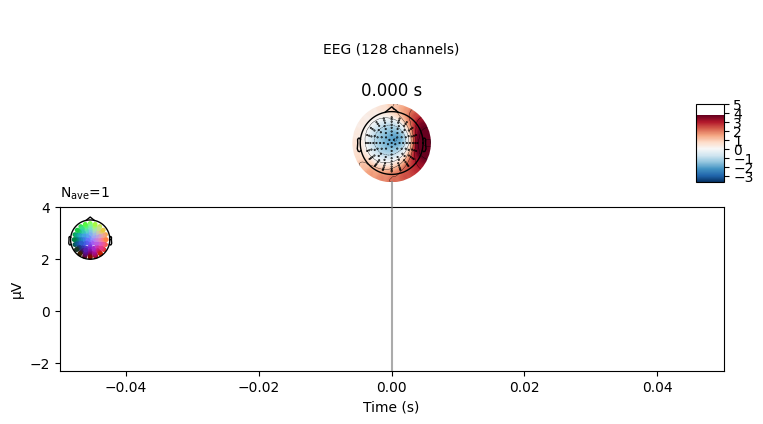

In [179]:
from scipy.stats import pearsonr
from invert.util import find_corner, calc_residual_variance
from invert import Solver
max_iter = 10
K = 1
X_test = evoked.data
X_test -= X_test.mean(axis=0)

# dimensions
n_chans, n_dipoles = leadfield.shape
n_time = X_test.shape[-1]

# Predict Gammas
if len(X_test.shape) == 3:
    X_test = X_test[0]

# get initial orthogonal leadfield components
R = deepcopy(X_test)
R -= R.mean(axis=0)
R /= R.std(axis=0)
# rescale_norms = R.std(axis=0)
# R_normed = R / rescale_norms
# rescale_norms /= rescale_norms.mean()

# gammas_model = model.predict(get_components(R.T[:, np.newaxis], leadfield_norm)[np.newaxis], verbose=0)[0,0]
gammas_model = abs(model.predict(R.T[np.newaxis])[0,0])

gammas_model /= gammas_model.max()

residual_norms = [1e99,]
idc = np.array([])
for i in range(max_iter):
    stc_ = stc.copy()

    # gammas_model = model.predict(get_components(R.T[:, np.newaxis], leadfield_norm)[np.newaxis], verbose=0)[0,0]
    # gammas_model = abs(model.predict(R.T[np.newaxis])[0,0])
    # gammas_model /= gammas_model.max()
    
    mp = (leadfield_norm.T @ R )
    # mp *= rescale_norms
    gammas_mp = np.linalg.norm(mp, axis=1, ord=1)
    gammas_mp /= gammas_mp.max()
    
    gammas = gammas_model * gammas_mp
    # gammas = gammas_mp

    # stc_.data[:,0] = gammas_model
    # stc_.data[:,1] = gammas_mp
    # stc_.data[:,2] = gammas
    # stc_.plot(**pp, brain_kwargs=dict(title=f'{i} Gammas'))

    idx = np.argsort(gammas)[-K:]

    # arg_sorted = np.argsort(gammas)[::-1]
    # ii = 0
    # idx = arg_sorted[ii]
    # while idx in idc:
    #     print("idx reselected")
    #     ii += 1
    #     idx = arg_sorted[ii]

    idc = np.unique(np.append(idc, idx)).astype(int)

    # Remove IDC that dont really explain variance in the whole data
    # Inversion
    # corrs = np.mean(abs((leadfield_norm.T @ X_test)), axis=1)[idc]
    # highest_K = corrs > corrs.max()/2#np.argsort(corrs)[-K:]
    # idc = idc[highest_K]

    print(idc)

    # Inversion
    leadfield_pinv = np.linalg.pinv(leadfield[:, idc])
    y_hat = np.zeros((n_dipoles, n_time))
    y_hat[idc] = leadfield_pinv @ X_test

    X_hat = leadfield @ y_hat
    # Rereference predicted EEG
    X_hat -= X_hat.mean(axis=0)
    
    # Calculate Residual
    R = X_test - X_hat
    R -= R.mean(axis=0)

    # Rereference and scale predicted Residual
    
    
    residual_norm = np.linalg.norm(R)
    residual_norms.append( residual_norm )
    
    # rescale_norms = R.std(axis=0)

    # R_normed = R / rescale_norms
    # rescale_norms /= rescale_norms.mean()

    # print(idc)
    # print(residual_norm)
    rv = calc_residual_variance(X_hat, X_test)
    print(i, " Res var: ", rv)
    # break


    # evoked_true = mne.EvokedArray(X_test, info, verbose=0)
    # evoked_hat = mne.EvokedArray(X_hat, info, verbose=0)
    # evoked_res = mne.EvokedArray(R, info, verbose=0)
    # evoked_true.plot_joint(title="True")
    # evoked_hat.plot_joint(title="Current X_hat")
    # evoked_res.plot_joint(title="Residual")

    # stc_.data = y_hat
    # stc_.plot(**pp, brain_kwargs=dict(title=f"Prediction {i}"))
    # if residual_norms[-1] >= residual_norms[-2] or rv<1:
    if rv<0.1:
    
        break
    
X_hat = leadfield@y_hat

stc_ = stc.copy()
stc_.data = y_hat / abs(y_hat).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Pred', 'title',
               font_size=14)

x_hat = leadfield@y_hat

evoked_ = mne.EvokedArray(x_hat, info)
evoked_.plot_joint()

No projector specified for this dataset. Please consider the method self.add_proj.


c:\Users\lukas\virtualenvs\invertenv\lib\site-packages\mne\viz\evoked.py:521: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


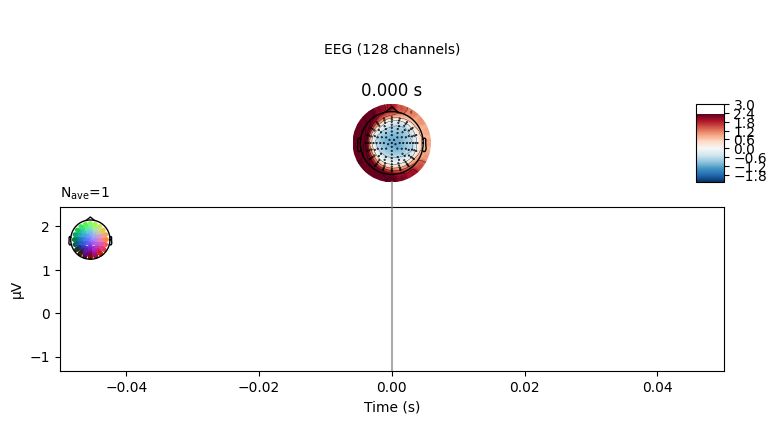

In [230]:
stc_ = stc.copy()
stc_.data = y_hat / abs(y_hat).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Pred', 'title',
               font_size=14)

x_hat = leadfield@y_hat

evoked_ = mne.EvokedArray(x_hat, info)
evoked_.plot_joint()

# Champagne for scale

In [ ]:
solver = Solver("champagne")
solver.make_inverse_operator(fwd, alpha=1e-3)
stc_champ = solver.apply_inverse_operator(mne.EvokedArray(X_test, info))
stc_champ.plot(**pp, brain_kwargs=dict(title="Champ"))